# Early vs Late Apex Analysis: Advanced Racing Line Optimization

This notebook extends my previous optimal racing line analysis to investigate different apex strategies used in motorsports. Early and late apex strategies are fundamental technique that can significantly impact lap times depending on the track layout.

## Introduction to Apex Strategies

In motorsports, the **apex** is the point where the car is closest to the inside of the corner.

**Geometric Apex:**
This is the point at the center of the constant radius of the corner. It's the shortest distance across the corner.

**Early Apex:**
This is when the driver turns in towards the inside of the corner earlier than the geometric apex, potentially creating a tighter turn. This can be useful in some situations to set up for the next corner, but it may also reduce exit speed. 

**Late Apex:**
This involves turning in later than the geometric apex, creating a wider entry and a later turn-in point. This approach can be useful for maximizing exit speed, especially in corners where a good exit is crucial for the following section of the track. 

## Track Setup

A 90-degree corner with a 50 meter radius, similar to the original analysis, but with a more sophiscated race lines to demonstrate different cornering strategies.

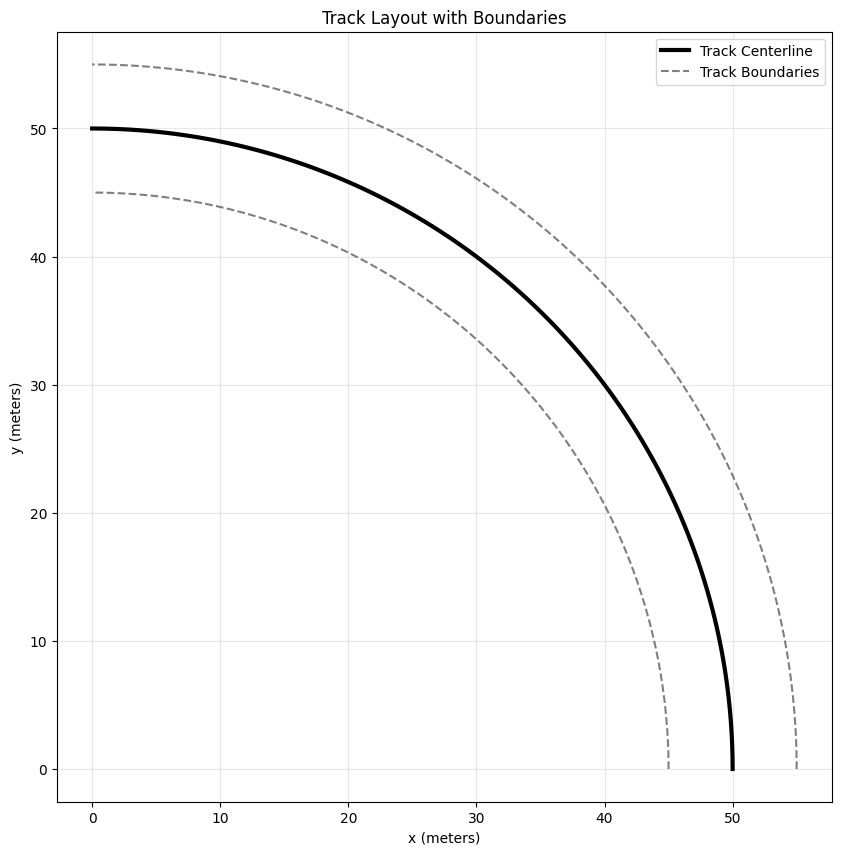

In [9]:
import numpy as np
import matplotlib.pyplot as plt

track_radius = 50
num_points = 200

theta = np.linspace(0, np.pi/2, num_points)
x_track = track_radius * np.cos(theta)
y_track = track_radius * np.sin(theta)

plt.figure(figsize=(10, 10))
plt.plot(x_track, y_track, 'k-', linewidth=3, label='Track Centerline')

track_width = 10
x_inner = (track_radius - track_width/2) * np.cos(theta)
y_inner = (track_radius - track_width/2) * np.sin(theta)
x_outer = (track_radius + track_width/2) * np.cos(theta)
y_outer = (track_radius + track_width/2) * np.sin(theta)

plt.plot(x_inner, y_inner, 'k--', alpha=0.5, label='Track Boundaries')
plt.plot(x_outer, y_outer, 'k--', alpha=0.5)

plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.title('Track Layout with Boundaries')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Creating Apex Racing Lines

Now we'll create functions to generate different apex strategies. Each strategy will have a different line shape that represents how professional drivers approach corners.

Apex Strategies:
Early Apex: radius 46.5m at 0% into corner
Late Apex: radius 46.5m at 100% into corner
Geometric Apex: radius 50m at 50% into corner


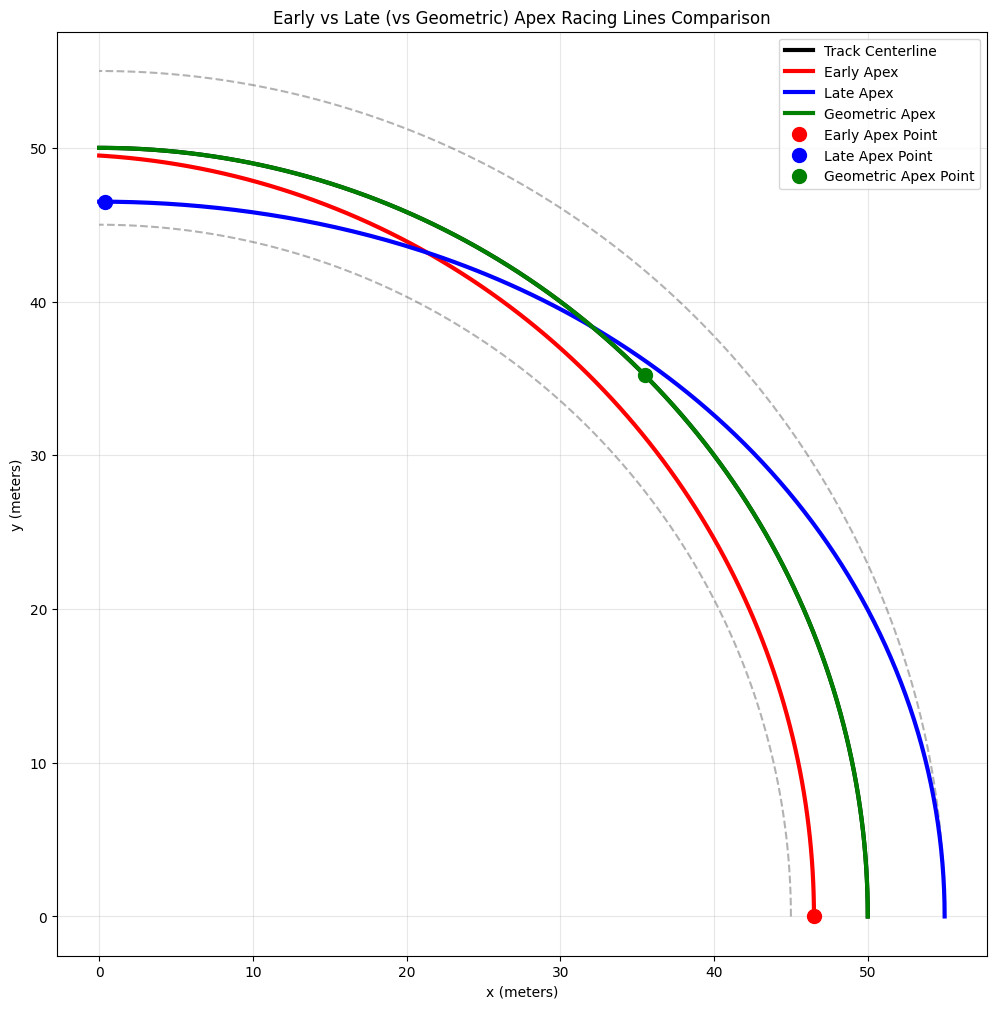

In [10]:
def create_apex_line(apex_radius, apex_point, track_radius, num_points=200):
    """
     apex_radius: radius from ceter to the apex point
     apex_point: where the apex is at (0 to 1, where 0.5 is the geometric apex)
     track_radius: radius of the track centerline
     num_points: number of points to generate
    """
    theta = np.linspace(0, np.pi/2, num_points)
    
    x_line = np.zeros(num_points)
    y_line = np.zeros(num_points)
    
    for i, t in enumerate(theta):
        # normalised points
        corner_progress = t / (np.pi/2)
        
        # using cosine interpolation
        if corner_progress < apex_point:
            # entry
            progress_to_apex = corner_progress / apex_point
            factor = 0.5 * (1 - np.cos(progress_to_apex * np.pi))
            current_radius = track_radius + (apex_radius - track_radius) * factor
        else:
            # exit
            progress_from_apex = (corner_progress - apex_point) / (2 - apex_point)
            factor = 0.5 * (1 - np.cos(progress_from_apex * np.pi))
            current_radius = apex_radius + (track_radius - apex_radius) * factor
        
        x_line[i] = current_radius * np.cos(t)
        y_line[i] = current_radius * np.sin(t)
    
    return x_line, y_line

# apex strats
early_apex_radius = track_radius - 3.5
early_apex_point = 0

late_apex_radius = track_radius - 3.5
late_apex_point = 1

geo_apex_radius = track_radius
geo_apex_point = 0.5

print("Apex Strategies:")
print(f"Early Apex: radius {early_apex_radius}m at {early_apex_point*100:.0f}% into corner")
print(f"Late Apex: radius {late_apex_radius}m at {late_apex_point*100:.0f}% into corner")
print(f"Geometric Apex: radius {geo_apex_radius}m at {geo_apex_point*100:.0f}% into corner")

# diff apex lines
x_early, y_early = create_apex_line(early_apex_radius, early_apex_point, 52.5)
x_late, y_late = create_apex_line(late_apex_radius, late_apex_point, 55)
x_geo, y_geo = create_apex_line(geo_apex_radius, geo_apex_point, 50)

plt.figure(figsize=(12, 12))

### PLOTTING

plt.plot(x_track, y_track, 'k-', linewidth=3, label='Track Centerline')
plt.plot(x_inner, y_inner, 'k--', alpha=0.3)
plt.plot(x_outer, y_outer, 'k--', alpha=0.3)

plt.plot(x_early, y_early, 'r-', linewidth=3, label='Early Apex')
plt.plot(x_late, y_late, 'b-', linewidth=3, label='Late Apex')
plt.plot(x_geo, y_geo, 'g-', linewidth=3, label='Geometric Apex')

early_idx = int(early_apex_point * (len(x_early)-1))
late_idx = int(late_apex_point * (len(x_late)-2))
geo_idx = int(geo_apex_point * (len(x_geo)-1))

plt.plot(x_early[early_idx], y_early[early_idx], 'ro', markersize=10, label='Early Apex Point')
plt.plot(x_late[late_idx], y_late[late_idx], 'bo', markersize=10, label='Late Apex Point')
plt.plot(x_geo[geo_idx], y_geo[geo_idx], 'go', markersize=10, label='Geometric Apex Point')

plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.title('Early vs Late (vs Geometric) Apex Racing Lines Comparison')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Performance Analysis

Analyzing the performance characteristics of each apex strategy. Key metrics like line length, minimum radius, maximum speed, and estimated corner time are calculated.

In [11]:
def calculate_apex_performance(x_line, y_line, car_specs):

    # line length
    dx = np.diff(x_line)
    dy = np.diff(y_line)
    line_length = np.sum(np.sqrt(dx**2 + dy**2))
    
    # radius at each point
    radii = np.sqrt(x_line**2 + y_line**2)
    min_radius = np.min(radii)
    max_radius = np.max(radii)
    avg_radius = np.mean(radii)
    
    # speeds at different points
    g = 9.81
    max_lateral_a = car_specs['max_lateral_g'] * g
    
    # speed at min radius (tightest point)
    min_speed = np.sqrt(max_lateral_a * min_radius)
    
    # simplified avg speed 
    avg_speed = np.sqrt(max_lateral_a * avg_radius)
    
    # estimated corner time
    corner_time = line_length / avg_speed
    
    return {
        'line_length': line_length,
        'min_radius': min_radius,
        'max_radius': max_radius,
        'avg_radius': avg_radius,
        'min_speed': min_speed,
        'avg_speed': avg_speed,
        'corner_time': corner_time,
    }

# dataset from previous notebook is used
car = {
    'mass': 1380+60, # (kg)     
    'max_lateral_g': 0.92, # (g)
    'max_accel': 4.0, # (m/s^2)
    'max_brake': 6.0 # (m/s^2)
}

# performance for each strat
early_perf = calculate_apex_performance(x_early, y_early, car)
late_perf = calculate_apex_performance(x_late, y_late, car)
geo_perf = calculate_apex_performance(x_geo, y_geo, car)

print("Performance Comparison:")
print(f"{'Metric':<15} {'Early Apex':<12} {'Late Apex':<12} {'Geometric':<12}")
print(f"{'Line Length (m)':<15} {early_perf['line_length']:<12.1f} {late_perf['line_length']:<12.1f} {geo_perf['line_length']:<12.1f}")
print(f"{'Min Radius (m)':<15} {early_perf['min_radius']:<12.1f} {late_perf['min_radius']:<12.1f} {geo_perf['min_radius']:<12.1f}")
print(f"{'Max Radius (m)':<15} {early_perf['max_radius']:<12.1f} {late_perf['max_radius']:<12.1f} {geo_perf['max_radius']:<12.1f}")
print(f"{'Avg Radius (m)':<15} {early_perf['avg_radius']:<12.1f} {late_perf['avg_radius']:<12.1f} {geo_perf['avg_radius']:<12.1f}")
print(f"{'Min Speed (m/s)':<15} {early_perf['min_speed']:<12.1f} {late_perf['min_speed']:<12.1f} {geo_perf['min_speed']:<12.1f}")
print(f"{'Avg Speed (m/s)':<15} {early_perf['avg_speed']:<12.1f} {late_perf['avg_speed']:<12.1f} {geo_perf['avg_speed']:<12.1f}")
print(f"{'Corner Time (s)':<15} {early_perf['corner_time']:<12.2f} {late_perf['corner_time']:<12.2f} {geo_perf['corner_time']:<12.2f}")

Performance Comparison:
Metric          Early Apex   Late Apex    Geometric   
Line Length (m) 74.8         80.3         78.5        
Min Radius (m)  46.5         46.5         50.0        
Max Radius (m)  49.5         55.0         50.0        
Avg Radius (m)  47.6         50.8         50.0        
Min Speed (m/s) 20.5         20.5         21.2        
Avg Speed (m/s) 20.7         21.4         21.2        
Corner Time (s) 3.61         3.75         3.70        


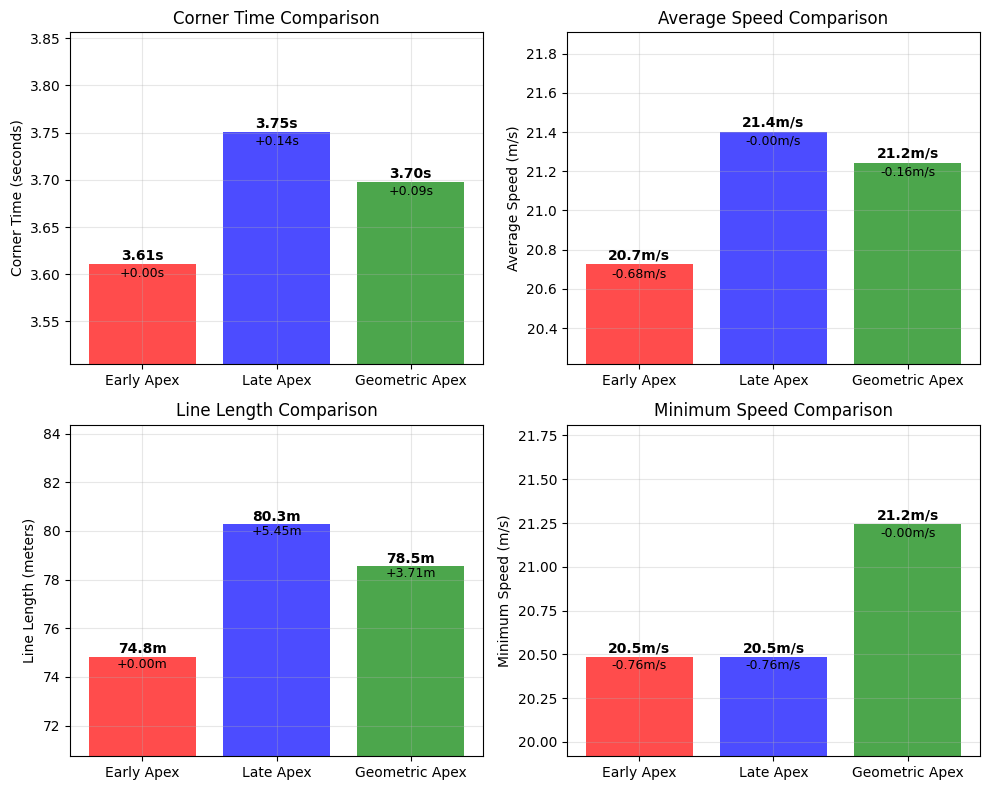

In [45]:
import matplotlib.pyplot as plt

strategies = ['Early Apex', 'Late Apex', 'Geometric Apex']
corner_times = [early_perf['corner_time'], late_perf['corner_time'], geo_perf['corner_time']]
avg_speeds = [early_perf['avg_speed'], late_perf['avg_speed'], geo_perf['avg_speed']]
line_lengths = [early_perf['line_length'], late_perf['line_length'], geo_perf['line_length']]
min_speeds = [early_perf['min_speed'], late_perf['min_speed'], geo_perf['min_speed']]

def set_zoomed_ylim(ax, values, margin=0.75):
    min_val, max_val = min(values), max(values)
    span = max_val - min_val
    if span == 0:
        ax.set_ylim(min_val - 1, max_val + 1)
    else:
        ax.set_ylim(min_val - margin * span, max_val + margin * span)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# corner time
bars1 = ax1.bar(strategies, corner_times, color=['red', 'blue', 'green'], alpha=0.7)
ax1.set_ylabel('Corner Time (seconds)')
ax1.set_title('Corner Time Comparison')
ax1.grid(True, alpha=0.3)
for bar, time in zip(bars1, corner_times):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{time:.2f}s', 
             ha='center', va='bottom', fontweight='bold')
set_zoomed_ylim(ax1, corner_times)
best = min(corner_times)
for bar, time in zip(bars1, corner_times):
    diff = time - best
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.003, f'+{diff:.2f}s', 
             ha='center', va='top', color='black', fontsize=9)

# avg speed
bars2 = ax2.bar(strategies, avg_speeds, color=['red', 'blue', 'green'], alpha=0.7)
ax2.set_ylabel('Average Speed (m/s)')
ax2.set_title('Average Speed Comparison')
ax2.grid(True, alpha=0.3)
for bar, speed in zip(bars2, avg_speeds):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{speed:.1f}m/s', 
             ha='center', va='bottom', fontweight='bold')
set_zoomed_ylim(ax2, avg_speeds)
best = max(avg_speeds)
for bar, speed in zip(bars2, avg_speeds):
    diff = best - speed
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.015, f'-{diff:.2f}m/s', 
             ha='center', va='top', color='black', fontsize=9)

# line length
bars3 = ax3.bar(strategies, line_lengths, color=['red', 'blue', 'green'], alpha=0.7)
ax3.set_ylabel('Line Length (meters)')
ax3.set_title('Line Length Comparison')
ax3.grid(True, alpha=0.3)
for bar, length in zip(bars3, line_lengths):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{length:.1f}m', 
             ha='center', va='bottom', fontweight='bold')
set_zoomed_ylim(ax3, line_lengths)
best = min(line_lengths)
for bar, length in zip(bars3, line_lengths):
    diff = length - best
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.03, f'+{diff:.2f}m', 
             ha='center', va='top', color='black', fontsize=9)

# min speed
bars4 = ax4.bar(strategies, min_speeds, color=['red', 'blue', 'green'], alpha=0.7)
ax4.set_ylabel('Minimum Speed (m/s)')
ax4.set_title('Minimum Speed Comparison')
ax4.grid(True, alpha=0.3)
for bar, speed in zip(bars4, min_speeds):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{speed:.1f}m/s', 
             ha='center', va='bottom', fontweight='bold')
set_zoomed_ylim(ax4, min_speeds)
best = max(min_speeds)
for bar, speed in zip(bars4, min_speeds):
    diff = best - speed
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.01, f'-{diff:.2f}m/s', 
             ha='center', va='top', color='black', fontsize=9)

plt.tight_layout()
plt.show()

## Speed Analysis Along the Corner

Analyzing how speed varies in each racing line to understand difference of each apex strategy.

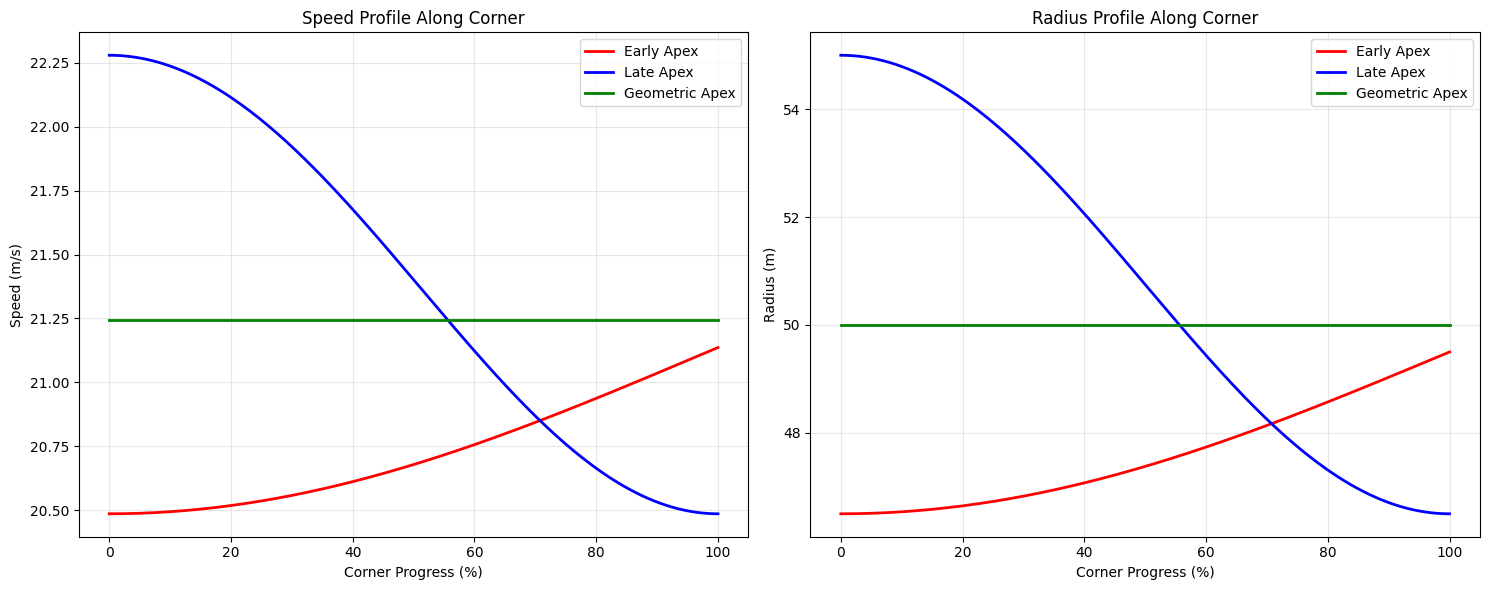

In [13]:
def calculate_speed_profile(x_line, y_line, car_specs):
    """Calculate speed profile along a racing line"""
    # radius at each point
    radii = np.sqrt(x_line**2 + y_line**2)
    
    # speed at each point
    g = 9.81
    max_lateral_a = car_specs['max_lateral_g'] * g
    speeds = np.sqrt(max_lateral_a * radii)
    
    # progress along the corner (0 to 1)
    progress = np.linspace(0, 1, len(speeds))
    
    return progress, speeds, radii

# speed profiles
progress_early, speeds_early, radii_early = calculate_speed_profile(x_early, y_early, car)
progress_late, speeds_late, radii_late = calculate_speed_profile(x_late, y_late, car)
progress_geo, speeds_geo, radii_geo = calculate_speed_profile(x_geo, y_geo, car)

# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# speed vs progress
ax1.plot(progress_early * 100, speeds_early, 'r-', linewidth=2, label='Early Apex')
ax1.plot(progress_late * 100, speeds_late, 'b-', linewidth=2, label='Late Apex')
ax1.plot(progress_geo * 100, speeds_geo, 'g-', linewidth=2, label='Geometric Apex')
ax1.set_xlabel('Corner Progress (%)')
ax1.set_ylabel('Speed (m/s)')
ax1.set_title('Speed Profile Along Corner')
ax1.grid(True, alpha=0.3)
ax1.legend()

# radius vs progress
ax2.plot(progress_early * 100, radii_early, 'r-', linewidth=2, label='Early Apex')
ax2.plot(progress_late * 100, radii_late, 'b-', linewidth=2, label='Late Apex')
ax2.plot(progress_geo * 100, radii_geo, 'g-', linewidth=2, label='Geometric Apex')
ax2.set_xlabel('Corner Progress (%)')
ax2.set_ylabel('Radius (m)')
ax2.set_title('Radius Profile Along Corner')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## Real-World Applications and Analysis

Analyzing the most beneficial scenarios for each apex strategy.

In [16]:
print("Real-World Racing Analysis")
print("=" * 50)

# 1. Corner leading to long straight
print("\nScenario 1: Corner leading to long straight")
print(f"Early Apex advantage: {early_perf['corner_time']:.2f}s (fastest)")
print(f"Late Apex time: {late_perf['corner_time']:.2f}s (+{late_perf['corner_time'] - early_perf['corner_time']:.2f}s)")
print(f"Geometric Apex time: {geo_perf['corner_time']:.2f}s (+{geo_perf['corner_time'] - early_perf['corner_time']:.2f}s)")
print("→ Early apex is best for maximizing exit speed onto long straights")

# 2. Corner leading to another corner
print("\nScenario 2: Corner leading to another corner")
print(f"Late Apex advantage: Higher entry speed possible")
print(f"Early Apex: Lower entry speed, earlier exit")
print("→ Late apex allows higher entry speed for the next corner")

Real-World Racing Analysis

Scenario 1: Corner leading to long straight
Early Apex advantage: 3.61s (fastest)
Late Apex time: 3.75s (+0.14s)
Geometric Apex time: 3.70s (+0.09s)
→ Early apex is best for maximizing exit speed onto long straights

Scenario 2: Corner leading to another corner
Late Apex advantage: Higher entry speed possible
Early Apex: Lower entry speed, earlier exit
→ Late apex allows higher entry speed for the next corner


## Conclusions 

### Early Apex Strategy:
- **Fastest corner time** in the simulation
- **Shortest line length** allows early acceleration
- **Lower minimum speed** due to tighter radius
- **Best for:** Corners leading to long straight line where exit speed is important
- **Examples:** Final corner at Monza, Turn 1 at Silverstone

### Late Apex Strategy:
- **Higher average speed** through the corner
- **Longer line** but allows higher entry speed
- **Best for:** Corners leading to short straight lines or another corner
- **Examples:** Chicanes, tight corner complexes like Monaco

### Geometric Apex:
- **Most consistent radius** = smoothest line
- **Best for:** Using as baseline to compare

### Technical Insights:

This analysis demonstrates the importance of considering the entire track sequence. The optimal strategy depends on what comes before and after the corner, showing the complexity of racing line optimization.

Furthermore, the simulation highlights that even small differences in apex placement can have significant impacts on lap times, which explains why professional drivers spend hours to perfect their racing lines.